# Popularity bias

Synthetic experiments that show how the method copes with non-uniform popularity

In [1]:
import collabclass
import numpy as np
import matplotlib.pyplot as plt
import pickle

Popularity model is roughly equal to SBM but each node draws a _popularity score_ from a Pareto distribution, and edge probabilities are proportional to these popularity scores.

In [2]:
def popularity_model(m, n, k, s, alpha):
    """Sparse & biased interaction model."""
    # Draw a class for each item.
    vs = np.random.choice(k, size=n, replace=True)
    # Draw a popularity score for each item.
    popularities = np.random.pareto(2.0, size=n)
    items_by_class = {cls: np.nonzero(vs == cls)[0] for cls in range(k)}
    # Draw a distribution for each user.
    us = np.random.dirichlet(alpha * np.ones(k), size=m)
    edges = list()
    for i in range(m):
        # Draw classes from user-specific class proportions.
        choices = np.random.multinomial(s, us[i])
        for cls, num in enumerate(choices):
            # Draw items from class `cls`.
            alts = items_by_class[cls]
            ps = popularities[alts] / np.sum(popularities[alts])
            items = np.random.choice(alts, size=num, replace=False, p=ps)
            edges.extend((i, j) for j in items)
    graph = collabclass.graph_from_edges(m, n, edges)
    return (us, vs, graph)

In [3]:
n = 1000
k = 5
s = 5
alpha = 0.5
delta = 0.1

ms = np.array([2500, 5000, 10000])
n_draws = 50

Degree distribution of a random sample of the popularity model.

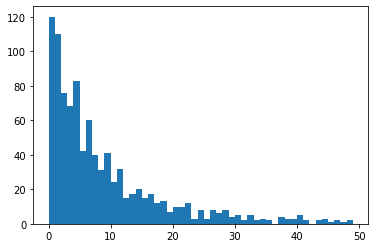

In [4]:
_, _, graph = popularity_model(m=ms[0], n=n, k=k, s=s, alpha=alpha)
plt.hist(graph.item_idx[:,1], bins=np.arange(50));

In [5]:
%%time
np.random.seed(0)

samples = np.zeros((len(ms), n_draws), dtype=object)
for i, m in enumerate(ms):
    for j in range(n_draws):
        # Tuple `(us, vs, graph)`.
        samples[i, j] = popularity_model(m=m, n=n, k=k, s=s, alpha=alpha)

CPU times: user 4min 3s, sys: 1.2 s, total: 4min 4s
Wall time: 4min 5s


In [6]:
min_degs = np.arange(1, 11, 1)

def experiment(predict):
    res = np.zeros((len(ms), n_draws, len(min_degs)))
    for i, m in enumerate(ms):
        print(".", end="", flush=True)
        for j in range(n_draws):
            us, vs, graph = samples[i, j]
            vs_hat = collabclass.symmetric_channel(vs, k, delta)
            # Run the predictor.
            vs_bar = predict(graph, vs_hat)
            # Evaluate accuracy.
            #fraction_connected = np.count_nonzero(graph.item_idx[:,1] > 0) / n
            correct = (vs == vs_bar)
            degrees = graph.item_idx[:,1]
            idx = np.argsort(degrees)
            zs = np.searchsorted(degrees[idx], min_degs, side="left")
            for a, z in enumerate(zs):
                res[i,j,a] = 1.0 - np.count_nonzero(correct[idx][z:]) / (n - z)
    print()
    return res

### CAVI

In [7]:
%%time
np.random.seed(0)
delta_inf = 0.75

def cavi(graph, vs_hat):
    alpha_prior = alpha * np.ones((len(graph.user_idx), k))
    beta_prior = collabclass.init_beta(k, vs_hat, delta_inf)
    _, beta = collabclass.cavi(graph, alpha_prior, beta_prior, n_iters=10)
    return np.argmax(beta, axis=1)

res_cavi = experiment(cavi)

...
CPU times: user 12.5 s, sys: 75.2 ms, total: 12.6 s
Wall time: 12.7 s


### wvRN

In [8]:
%%time
np.random.seed(0)
res_wvrn = experiment(collabclass.wvrn)

...
CPU times: user 470 ms, sys: 5.89 ms, total: 476 ms
Wall time: 477 ms


### Plot data

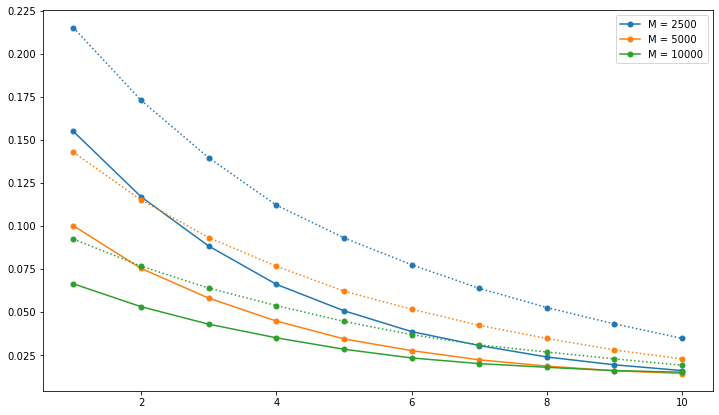

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))
for i, m in enumerate(ms):
    ax.plot(min_degs, np.nanmean(res_cavi[i], axis=0),
            color=plt.cm.tab10(i), marker="o", ms=5, label=f"M = {m}")
    ax.plot(min_degs, np.nanmean(res_wvrn[i], axis=0),
            color=plt.cm.tab10(i), marker="o", ms=5, ls=":")
ax.legend()